In [1]:
from ultralytics import YOLO
import cv2
import pandas as pd
import numpy as np
import os
from PIL import Image
from pathlib import Path
# import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import pillow_heif
import sys
import imutils
from operator import itemgetter
from glob import glob
from scipy.spatial import distance as dist
import pytesseract
import json
import re
from function.e_slip.ocr_tesseract import ocr_pytesseract

# Register HEIC support
pillow_heif.register_heif_opener()
def convert_heic_or_heif_to_jpeg(filepath):
    try:
        img = Image.open(filepath).convert("RGB")
        return np.array(img)  # Return image as NumPy array
    except Exception as e:
        return None 

# resize image for display
def resize(image, max_width=1280, max_height=720):
    height, width = image.shape[:2]
    scale = min(max_width / width, max_height / height)
    if scale < 1.0:
        image = cv2.resize(image, (int(width * scale), int(height * scale)))
    return image

def get_4_coordinates(binary,gray_image):
    # find the largest contour in the threshold image
    cnts = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    (x, y, w, h) = cv2.boundingRect(c)

    # to demonstrate the impact of contour approximation -> loop over a number of epsilon sizes
    for eps in np.linspace(0.001, 0.05, 10):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, eps * peri, True)

        # draw the approximated contour on the image
        detected_4_coor_with_contour = gray_image.copy()
        cv2.drawContours(detected_4_coor_with_contour, [approx], -1, (0, 255, 0), 3)
        text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
        cv2.putText(detected_4_coor_with_contour, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        if len(approx)==4:
            break

    if len(approx)==4:
        corners = approx.reshape(4, 2)  # reshape to (4, 2) for convenience
        for i, point in enumerate(corners):
            x, y = point

        # sort the corners for perspective transform
        # Use top-left, top-right, bottom-right, bottom-left order
        def sort_corners(pts):
            pts = pts[np.argsort(pts[:, 1])]  # sort by y (top to bottom)
            top, bottom = pts[:2], pts[2:]
            # sort top by x (left to right)
            top = top[np.argsort(top[:, 0])]
            # sort bottom by x (left to right, not reversed anymore)
            bottom = bottom[np.argsort(bottom[:, 0])]
            # order: TL, TR, BL, BR
            return np.array([top[0], top[1], bottom[0], bottom[1]])

        ordered_corners = sort_corners(corners)
    else:
        print(f"ERROR: Got {len(approx)} points — not a quadrilateral. Try adjusting epsilon.")
        sys.exit(0)
    
    return ordered_corners, detected_4_coor_with_contour

def bkk_extracted(lines):
    def clean_text(text):
        return text.replace('O', '0').replace('o', '0').replace('I', '1').replace('l', '1').replace(',', '').replace('฿', '').strip()

    # Regex patterns
    date_pattern = r"\b\d{2}/\d{2}/\d{2}\b" 
    time_pattern = r"\b\d{2}:\d{2}\b" 
    withdrawal_pattern = r"\bWITHDRAWAL\b"
    amount_pattern = r"\b\d{1,3}(?:,\d{3})*(?:\.\d{2})\b" 
    avail_bal_label_pattern = r"AVAIL\s+BAL"
    
    extracted = {
        "date": None,
        "time": None,
        "transaction_type": None,
        "withdrawal_amount": None,
        "available_balance": None
    }

    for i, raw_line in enumerate(lines):
        line = clean_text(raw_line.upper())

        # Extract date
        if not extracted["date"]:
            match = re.search(date_pattern, line)
            if match:
                extracted["date"] = match.group()

        # Extract time
        if not extracted["time"]:
            match = re.search(time_pattern, line)
            if match:
                extracted["time"] = match.group()

        # Extract transaction type
        if not extracted["transaction_type"]:
            if re.search(withdrawal_pattern, line):
                extracted["transaction_type"] = "WITHDRAWAL"

        # Extract withdrawal amount (the line usually contains the word WITHDRAWAL)
        if extracted["transaction_type"] == "WITHDRAWAL" and not extracted["withdrawal_amount"]:
            if "WITHDRAWAL" in line and i+1 < len(lines):
                # Check current or next line for amount
                current_line_match = re.search(amount_pattern, line)
                next_line_match = re.search(amount_pattern, clean_text(lines[i+1].upper()))
                if current_line_match:
                    extracted["withdrawal_amount"] = current_line_match.group()
                elif next_line_match:
                    extracted["withdrawal_amount"] = next_line_match.group()

        # Extract available balance
        if re.search(avail_bal_label_pattern, line):
            match = re.search(amount_pattern, line)
            if match:
                extracted["available_balance"] = match.group()
            elif i + 1 < len(lines):
                # Try next line if not found on current
                next_match = re.search(amount_pattern, clean_text(lines[i + 1].upper()))
                if next_match:
                    extracted["available_balance"] = next_match.group()

    return extracted

def kplus_extracted(lines):

    extracted_data = {
        "date": None,
        "time": None,
        "transaction_type": None,
        "from_account": None,
        "withdrawal_amount": None,
        "fee_amount": None,
        "account_balance": None
    }

    date_pattern = r"DATE\s*(\d{2}[/°oOo']?\d{2}[/°oOo']?\d{2})"
    time_pattern = r"TIME\s*(\d{2}:\d{2})"  
    withdrawal_pattern = r"(WITHDRAWAL)"
    from_account_pattern = r"FROM\s*ACCOUNT\s*([A-Z0-9]+)"
    amount_pattern = r"AMOUNT\s*([\d,]+\.\d{2})"
    fee_amount_pattern = r"FEE\s*AMOUNT\s*([\d,]+\.\d{2})"
    ac_balance_pattern = r"AC\s*BALANCE\s*([\d,]+\.\d{2})"

    for i, line in enumerate(lines):
        line_clean = line.replace('°', '0').replace('o', '0').replace('O', '0').strip()

        # extrcact DATE
        date_match = re.search(date_pattern, line_clean, re.IGNORECASE)
        if date_match and extracted_data["date"] is None:
            extracted_data["date"] = date_match.group(1).replace("'", "/")

        # extract TIME
        time_match = re.search(time_pattern, line_clean, re.IGNORECASE)
        if time_match and extracted_data["time"] is None:
            extracted_data["time"] = time_match.group(1) + ":00"

        # extract type of transaction (WITHDRAWAL)
        withdrawal_match = re.search(withdrawal_pattern, line_clean, re.IGNORECASE)
        if withdrawal_match and extracted_data["transaction_type"] is None:
            extracted_data["transaction_type"] = withdrawal_match.group(1).upper()

        # extract FROM ACCOUNT
        from_account_match = re.search(from_account_pattern, line_clean, re.IGNORECASE)
        if from_account_match and extracted_data["from_account"] is None:
            extracted_data["from_account"] = from_account_match.group(1)

        # extract AMOUNT (Withdrawal Amount)
        amount_match = re.search(amount_pattern, line_clean, re.IGNORECASE)
        if amount_match and extracted_data["withdrawal_amount"] is None:
            extracted_data["withdrawal_amount"] = amount_match.group(1)

        # extract FEE AMOUNT
        fee_amount_match = re.search(fee_amount_pattern, line_clean, re.IGNORECASE)
        if fee_amount_match and extracted_data["fee_amount"] is None:
            extracted_data["fee_amount"] = fee_amount_match.group(1)

        # extract A/C BALANCE
        ac_balance_match = re.search(ac_balance_pattern, line_clean, re.IGNORECASE)
        if ac_balance_match and extracted_data["account_balance"] is None:
            extracted_data["account_balance"] = ac_balance_match.group(1)

    return extracted_data

def krungthai_extracted(lines):

    extracted_data = {
        "date": None,
        "time": None,
        "transaction_type": None,
        "deposit_amount": None,
        "ac_name": None
    }

    date_pattern = r"DATE\s*([\d]{2}/[\d]{2}/[\d]{2})"
    time_pattern = r"TIME\s*([\d]{2}:[\d]{2})"
    deposit_pattern = r"(AUTO\s*DEP)"
    amount_pattern = r"จำนวนเงิน\s*([\d,]+\.\d{2})\s*BAHT"
    ac_name_pattern = r"To A/C Name\s*:\s*(.+)"

    for line in lines:
        line_clean = line.strip()

        # extract DATE
        date_match = re.search(date_pattern, line_clean, re.IGNORECASE)
        if date_match and extracted_data["date"] is None:
            extracted_data["date"] = date_match.group(1)

        # extract TIME
        time_match = re.search(time_pattern, line_clean, re.IGNORECASE)
        if time_match and extracted_data["time"] is None:
            extracted_data["time"] = time_match.group(1) + ":00"

        # extract type of transaction (AUTO DEP)
        deposit_match = re.search(deposit_pattern, line_clean, re.IGNORECASE)
        if deposit_match and extracted_data["transaction_type"] is None:
            extracted_data["transaction_type"] = deposit_match.group(1)

        # extract deposit amount
        amount_match = re.search(amount_pattern, line_clean, re.IGNORECASE)
        if amount_match and extracted_data["deposit_amount"] is None:
            extracted_data["deposit_amount"] = amount_match.group(1)

        # extract A/C Name
        ac_name_match = re.search(ac_name_pattern, line_clean)
        if ac_name_match and extracted_data["ac_name"] is None:
            extracted_data["ac_name"] = ac_name_match.group(1).strip()


    return extracted_data


0: 640x480 1 bkk, 88.3ms
Speed: 3.4ms preprocess, 88.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
classname: bkk, conf: 0.9333990216255188


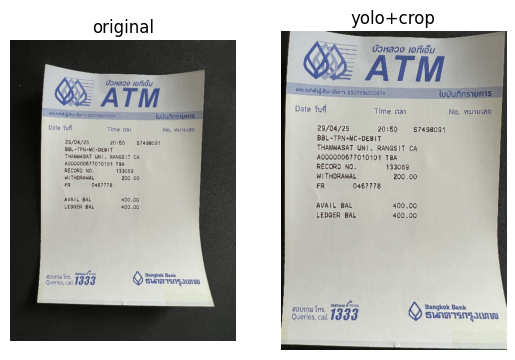

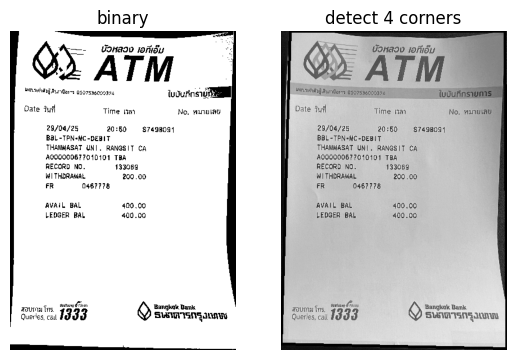

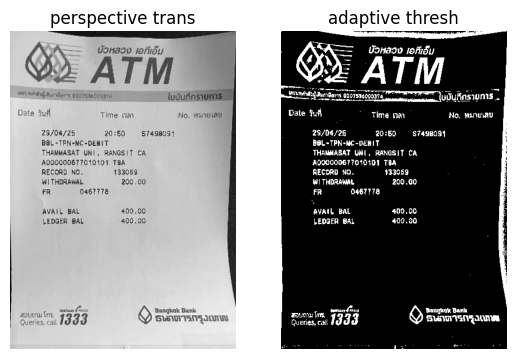

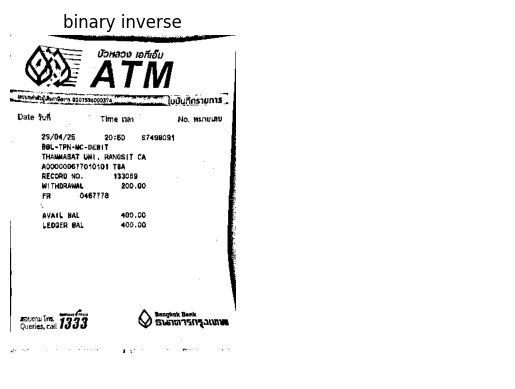

**************************
{
  "date": "29/04/25",
  "time": null,
  "transaction_type": null,
  "withdrawal_amount": null,
  "available_balance": null
}
**************************


In [2]:
def physicalReceipt(image_path, model_path=r'models\best.pt'):

    # supported filetype
    img_ext_list = ['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG','.bmp','.BMP']

    # check image type
    file_extension = os.path.splitext(image_path)[1]
    # change image type(if .heif/.heic)
    if file_extension in img_ext_list:
        # read image
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    elif (file_extension=='.HEIC'or file_extension=='.heic'or file_extension=='.HEIF'or file_extension=='.heif'):
        # convert to .JPEG
        image = convert_heic_or_heif_to_jpeg(image_path) # return as np array
        if image is None:
            print('ERROR: HEIC/HEIF file conversion failed. Please check the file.')
            sys.exit(0)
    else:
        print(f'Input {image_path} is invalid. Please try again.')
        sys.exit(0)

    # load YOLO model and get labelmap
    model = YOLO(model_path, task='detect') # task='detect' => obj detection => get bb and class
    labels = model.names # is to map between class id and classname 

    # resize for appropriate scale
    image = resize(image)

    # rescale color scale -> effect model's confidence percentage
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # -------image preprocessing--------
    # run detection
    results = model(image)
    # get the results
    detections = results[0].boxes

    # project scope => 1 image = 1 receipt
    for i in range(0,1): # if there are several obj, get the first one
        # get bounding box coordinates
        # Ultralytics returns results in Tensor format, which have to be converted to a regular Python array
        xyxy_tensor = detections[i].xyxy.cpu() # Detections in Tensor format in CPU memory
        xyxy = xyxy_tensor.numpy().squeeze() # Convert tensors to Numpy array
        xmin, ymin, xmax, ymax = xyxy.astype(int) # Extract individual coordinates and convert to int

        # get classname
        classidx = int(detections[i].cls.item())
        classname = labels[classidx] # map to get classname of the obj

        # get confidence
        conf = detections[i].conf.item()

        # cropped 
        # roi = img[y1:y2,x1:x2]
        after_yolo = image[ymin:ymax,xmin:xmax]

    # ---perspective transformation---
    # edge detection
    gray_image = cv2.cvtColor(after_yolo, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # get 4 coordinates for perspective transformation
    # optimize image before go get 4 coordinates
    blurred = cv2.GaussianBlur(gray_image,(3,3),0) 
    thresh = cv2.adaptiveThreshold(blurred, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 10)
    _,binaryInv = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY_INV)
    # get 4 coordinates
    # corners' order=TL, TR, BL, BR
    corners, detected_4_coor_with_contour = get_4_coordinates(binaryInv,gray_image) #binary
    # for i,(x,y) in enumerate(corners):
    #     print(f"Corner {i + 1}: (x={x}, y={y})")
    
    #assign corners
    topLeft = corners[0]
    topRight = corners[1]
    bottomLeft = corners[2]
    bottomRight = corners[3]
    x1, y1 = topLeft
    x2, y2 = topRight
    x3, y3 = bottomLeft
    x4, y4 = bottomRight

    # euclidean (distance between 2 points in linear)
    upperLine = dist.euclidean((x1,y1),(x2,y2))
    lowerLine = dist.euclidean((x3,y3),(x4,y4))
    leftmostLine = dist.euclidean((x1,y1),(x3,y3))
    rightmostLine = dist.euclidean((x2,y2),(x4,y4))

    width = round(max(upperLine,lowerLine))
    height = round(max(leftmostLine, rightmostLine))

    # print(f"upperline: {upperLine}")
    # print(f"lowerLine: {lowerLine}")
    # print(f"leftmostLine: {leftmostLine}")
    # print(f"rightmostLine: {rightmostLine}")
    # print(f"width: {width}")
    # print(f"height: {height}")

    # perspective transformation
    if height>=width: # normal case
        pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]]) # original coordinates
        pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]]) # transformed pixel
        M = cv2.getPerspectiveTransform(pts1,pts2)
        perspective_trans = cv2.warpPerspective(gray_image,M,(width,height))
    if width>height: # 180 degree case -> need rotation -> in case photo flip accidentally
        pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]]) # original coordinates
        pts2 = np.float32([[0,width],[0,0],[height,width],[height,0]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        perspective_trans = cv2.warpPerspective(gray_image,M,(height,width))

    # adaptive thresholding -> for handle image with shadow
    # blur for make edges softer
    blurred = cv2.GaussianBlur(perspective_trans,(3,3),0) 
    
    thresh = cv2.adaptiveThreshold(perspective_trans, 255,
                                   cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY_INV, 21, 10)
    _,binaryInv = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY_INV)

    # --------OCR--------
    # pytesseract
    custom_config = r'--oem 3 --psm 6'
    textPytess = pytesseract.image_to_string(binaryInv, lang='tha+eng', config=custom_config)               
    #perspective_trans
    # print("-----------PYTESSERACT------------")
    # print(textPytess)

    lines = textPytess.splitlines()

    with open("pytesseract.json", "w", encoding="utf-8") as f:
        json.dump({"lines": lines}, f, ensure_ascii=False, indent=4)

    # regex
    extracted_text = None

    if classname=='bkk':
        extracted_text = bkk_extracted(lines)

    if classname=='kplus':
        extracted_text = kplus_extracted(lines)
    
    if classname=='krungthai':
        extracted_text = krungthai_extracted(lines)

    if classname=='scb':
        extracted_text = lines


    # return json (info in image)
    return image, after_yolo, conf, classname, binary, detected_4_coor_with_contour, perspective_trans, thresh, binaryInv, extracted_text

# -----------test case--------------
# image file testing
image_path = r'dataset\bangkok\physical\IMG_4987.HEIC'
image, after_yolo, conf, classname, binary, detected_4_coor_with_contour, perspective_trans, thresh, binaryInv, extracted_text = physicalReceipt(image_path)
print(f"classname: {classname}, conf: {conf}")


plt.figure()
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # matplotlib = RGB
plt.axis('off')

plt.subplot(1,2,2)
plt.title("yolo+crop")
plt.imshow(cv2.cvtColor(after_yolo, cv2.COLOR_BGR2RGB)) # matplotlib = RGB
plt.axis('off')

plt.figure()
plt.subplot(1,2,1)
plt.title("binary")
plt.imshow(binary, cmap='gray') 
plt.axis('off')

plt.subplot(1,2,2)
plt.title("detect 4 corners")
plt.imshow(detected_4_coor_with_contour, cmap='gray') 
plt.axis('off')

plt.figure()
plt.subplot(1,2,1)
plt.title("perspective trans")
plt.imshow(perspective_trans, cmap='gray') 
plt.axis('off')

plt.subplot(1,2,2)
plt.title("adaptive thresh")
plt.imshow(thresh, cmap='gray') 
plt.axis('off')

plt.figure()
plt.subplot(1,2,1)
plt.title("binary inverse")
plt.imshow(binaryInv, cmap='gray') 
plt.axis('off')

plt.subplot(1,2,2)
# plt.title("adaptive thresh")
# plt.imshow(thresh, cmap='gray') 
plt.axis('off')

plt.show()

print("**************************")
print(json.dumps(extracted_text, indent=2))
print("**************************")
